# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        , -0.01416314,  0.06263459, ..., -0.44478035,
        -0.39163954, -0.33014548]),
 array([ 0.        ,  0.39594954,  0.27878635, ..., -0.55344109,
        -0.71057181, -0.62256885])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
# out_spikes

## Model Fitting

In [6]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau :volt
        dvt/dt = (a*v - vt) / taut :volt
        alpha : volt (constant)
        a : 1 (constant)
        R : ohm (constant)
        tau : second (constant)
        taut : second (constant)
        D: second (constant)
        '''
reset = '''
v = 0*mV
vt = vt + alpha
'''

In [7]:
set_device('cpp_standalone', directory='parallel', clean=False)

In [8]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=50*second, delta=2*ms)

In [9]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=100,
                     threshold='v > vt',
                     reset=reset,
                     refractory='D',
                     )

In [10]:
result_dict, error = fitter.fit(n_rounds=10,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[1,30]*mV,
                                a = [0.1, 5],
                                R = [1, 800]*Mohm, 
                                tau = [9, 80]*ms,
                                taut = [60, 160]*ms,
                                D = [0.5, 5]*ms,
                               )

Round 0: fit (0.04667591808515731, 0.009483321770189974, 125181848.92424573, 3.0858247677431385, 0.09463251865931659, 0.002553776766278851) with error: 0.06455383344459079
Round 1: fit (0.04010331130583539, 0.021139960925473947, 460117591.9143851, 0.962790150918003, 0.12576087799606817, 0.002631380020832029) with error: 0.03392461438807241
Round 2: fit (0.04010331130583539, 0.021139960925473947, 460117591.9143851, 0.962790150918003, 0.12576087799606817, 0.002631380020832029) with error: 0.03392461438807241
Round 3: fit (0.04010331130583539, 0.021139960925473947, 460117591.9143851, 0.962790150918003, 0.12576087799606817, 0.002631380020832029) with error: 0.03392461438807241
Round 4: fit (0.05130594900677706, 0.02015036848146547, 475372342.5605092, 1.2893236220471365, 0.12834054797763936, 0.00239218698812048) with error: 0.004382748285081464
Round 5: fit (0.05130594900677706, 0.02015036848146547, 475372342.5605092, 1.2893236220471365, 0.12834054797763936, 0.00239218698812048) with error:

In [11]:
result_dict

{'tau': 0.05285801037593567,
 'alpha': 0.01999490802602803,
 'R': 471543150.97240716,
 'a': 1.3302162743491779,
 'taut': 0.1268526813327074,
 'D': 0.002866650830030978}

In [29]:
print('D', in_unit(result_dict['D']*second, ms))
print('a', result_dict['a'])
print('tau', in_unit(result_dict['tau']*second, ms))
print('R', in_unit(result_dict['R']*ohm, Mohm))
print('taut', in_unit(result_dict['taut']*second, ms))
print('alpha', in_unit(result_dict['alpha']*volt, mV))

D 2.86665083 ms
a 1.395984835969274
tau 52.85801038 ms
R 471.54315097 Mohm
taut 126.85268133 ms
alpha 19.99490803 mV


In [12]:
error

0.0026862370237196315

In [13]:
1 - error

0.9973137629762804

In [14]:
device.reinit()
device.activate()

In [15]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
# print('spike times:', spikes)

In [16]:
print(len(out_spikes[0]))
print(len(spikes[0]))

918
985


In [17]:
print(len(out_spikes[1]))
print(len(spikes[1]))

1505
0


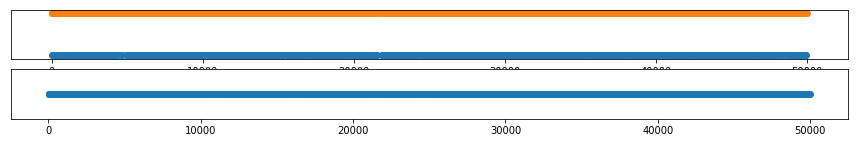

In [18]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

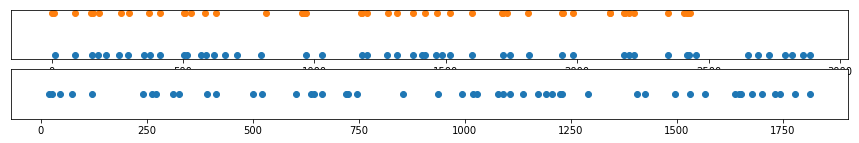

In [30]:
d=50


fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [20]:
device.reinit()
device.activate()

In [21]:
fits = fitter.generate(params=None, output_var='v',)

In [23]:
t0 = np.arange(0, len(voltage1)*dt, dt)
t_ = spikes[0]
t = spikes[0][t_<3000]

In [24]:
t

array([2.00000e-02, 1.03900e+01, 8.96800e+01, 1.50210e+02, 1.56790e+02,
       1.78710e+02, 2.65060e+02, 2.92910e+02, 3.70860e+02, 4.13630e+02,
       5.05080e+02, 5.07990e+02, 5.30060e+02, 5.83240e+02, 6.24710e+02,
       8.14180e+02, 9.52540e+02, 9.55400e+02, 9.58260e+02, 9.61120e+02,
       9.63980e+02, 9.67300e+02, 1.17871e+03, 1.18157e+03, 1.19887e+03,
       1.27807e+03, 1.31275e+03, 1.37435e+03, 1.42028e+03, 1.46483e+03,
       1.51590e+03, 1.59866e+03, 1.71487e+03, 1.71773e+03, 1.73101e+03,
       1.81469e+03, 1.94249e+03, 1.94535e+03, 1.98420e+03, 2.12365e+03,
       2.12651e+03, 2.17813e+03, 2.18099e+03, 2.19767e+03, 2.21781e+03,
       2.34554e+03, 2.40549e+03, 2.41777e+03, 2.42238e+03, 2.43030e+03,
       2.64639e+03, 2.64925e+03, 2.65211e+03, 2.68445e+03, 2.68731e+03,
       2.72893e+03, 2.81028e+03, 2.81740e+03, 2.85896e+03, 2.88181e+03,
       2.92875e+03, 2.98336e+03])

In [25]:
v = fits[0]
d = 300000

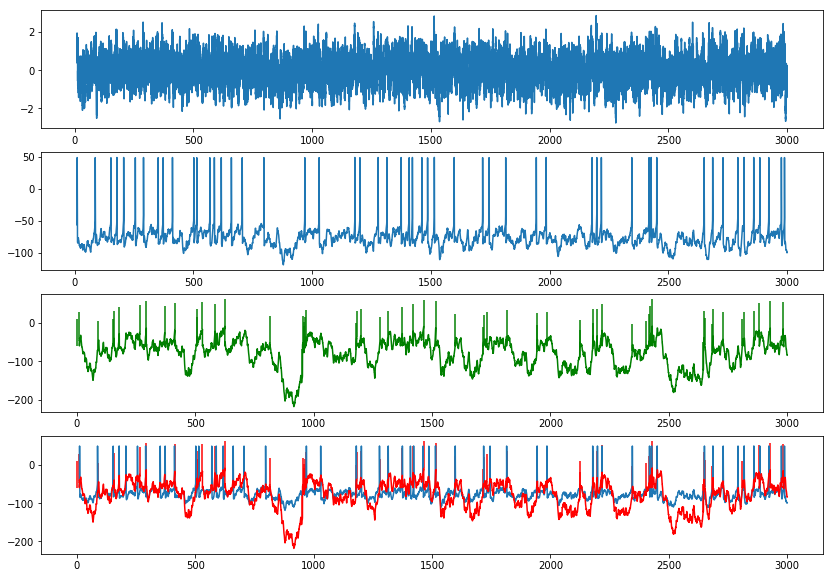

In [26]:
fig, ax = plt.subplots(nrows=4, figsize=(14,10))
ax[0].plot(t0[1000:d]/ms, inp_cur1[1000:d]);
ax[1].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[2].plot(t0[1000:d]/ms, v[1000:d]/mV-60, 'g')
ax[2].vlines(t, v[np.int_(np.round(t/dt*ms))]/mV+10, v[np.int_(np.round(t/dt*ms))]/mV-60, 'g');

ax[3].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[3].plot(t0[1000:d]/ms, v[1000:d]/mV-60, 'r')
ax[3].vlines(t, v[np.int_(np.round(t/dt*ms))]/mV+10, v[np.int_(np.round(t/dt*ms))]/mV-60, 'r');



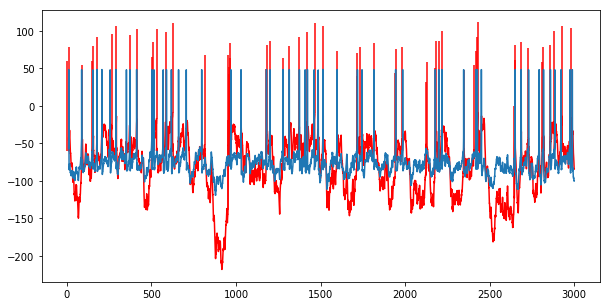

In [27]:
plt.figure(figsize=(10,5))
plot(t0[1000:d]/ms, v[1000:d]/mV-60, 'r')
vlines(t, v[np.int_(np.round(t/dt*ms))]/mV+60, v[np.int_(np.round(t/dt*ms))]/mV-60, 'r');
plot(t0[1000:d]/ms, voltage1[1000:d]);


In [28]:
param={'R': 38617749.58677548,
 'alpha': 0.006896191861644845,
 'taut': 0.0803213106795783,
 'tau': 0.013730585169469543,
 'a': 1.5549270966961934}
param

{'R': 38617749.58677548,
 'alpha': 0.006896191861644845,
 'taut': 0.0803213106795783,
 'tau': 0.013730585169469543,
 'a': 1.5549270966961934}